In [81]:
import numpy as np

from tensorflow.keras import (
    datasets,
    layers,
    models
)

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [82]:
(x_train, y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

In [83]:
def preprocess(imgs):
    # make sure that the pixel values are scaled between 0 and 1
    imgs = imgs.astype('float32') / 255.0
    # change image size to 32x32 for easier manipulation of the tensor shape as it passes through the net.
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)

    return imgs

def show_random_predictions(original_images, generated_images, n=5):
    # Выбираем случайные индексы
    random_indices = np.random.choice(original_images.shape[0], n, replace=False)

    # Настраиваем фигуру для отображения
    plt.figure(figsize=(10, 4))

    for i, idx in enumerate(random_indices):
        # Оригинальные изображения
        plt.subplot(2, n, i + 1)
        # Make image shape=32x32 by removing all axis=1
        plt.imshow(original_images[idx].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Сгенерированные изображения
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(generated_images[idx].squeeze(), cmap='gray')
        plt.title("Generated")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def show_random_predictions2(sample, generated_images, reconstructed_classes=0, n=5):
    n = min(n, sample.shape[0])
    random_indices = np.random.choice(sample.shape[0], n, replace=False)

    plt.figure(figsize=(18, 6))

    for i, idx in enumerate(random_indices):       
        plt.subplot(2, n, i + 1)
        plt.imshow(generated_images[idx].squeeze(), cmap='gray')
        coord = f"({sample[idx, 0]:.2f}, {sample[idx, 1]:.2f})"
        #category = f"Class: {reconstructed_classes[idx]}"
        #plt.title(f"{coord}\n{category}")
        plt.title(f"{coord}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**FAQ**

    -Q: What is Embeding?
    -A: The embeding is a compression of the original image into a lower-dimensional latent space

In [84]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# BUILD MODEL

## ENCODER

In [85]:
# Input is a b&w picture size of 32x32
# Output is a Tensor size of 32x32x1
encoder_input = layers.Input(
    shape=(32,32,1),
    name='encoder_input'    
)

# Input is a tensor from an encoder_input layer
# Output is the Tensor 16x16x32
x = layers.Conv2D(
    32,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(encoder_input)

# Input is the Tensor from layer above
# Output is the Tensor 8x8x64
x = layers.Conv2D(
    64,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(x)

#Input is the Tensor from layer above
#Output is the Tensor 4x4x128
x = layers.Conv2D(
    128,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(x)

# this var will save Tensor shape befoure flattening it 4x4x128
shape_befoure_flattening = K.int_shape(x)[1:]

# Outpuut is 4x4x128 = 2048
x = layers.Flatten()(x)

# Input vector of 2048 elements
# Output is 2 elemnts Vector(latent space)
encoder_output = layers.Dense(2,name='encoder_output')(x)

In [86]:
encoder = models.Model(encoder_input,encoder_output)

## DECODER

**CONVOLUTIONAL TRANSPOSE LAYERS**

The convolutional transpose layer uses the same principle as a standard convolutional layer (passing a filter across the image), but is different in that setting strides = 2  doubles the size of the input tensor in both dimensions. In a convolutional transpose layer, the strides parameter determines the internal zero padding between pixels in the image.

Parameters for demonstration bellow are:
- Filter/Kernel(gray): 3 × 3 × 1
- Stride: 2,
- Output(green): 6 × 6 × 1.

filter (gray) is being passed across a 3 × 3 × 1 image (blue) to produce output 6x6x1

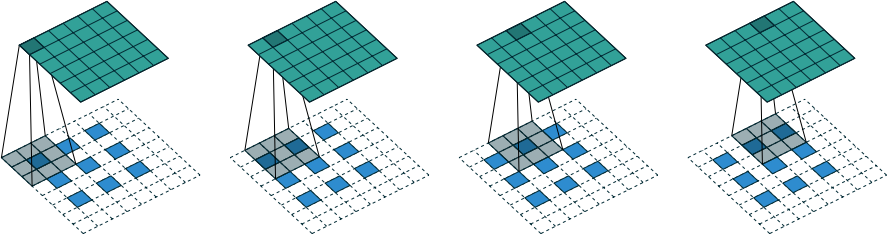

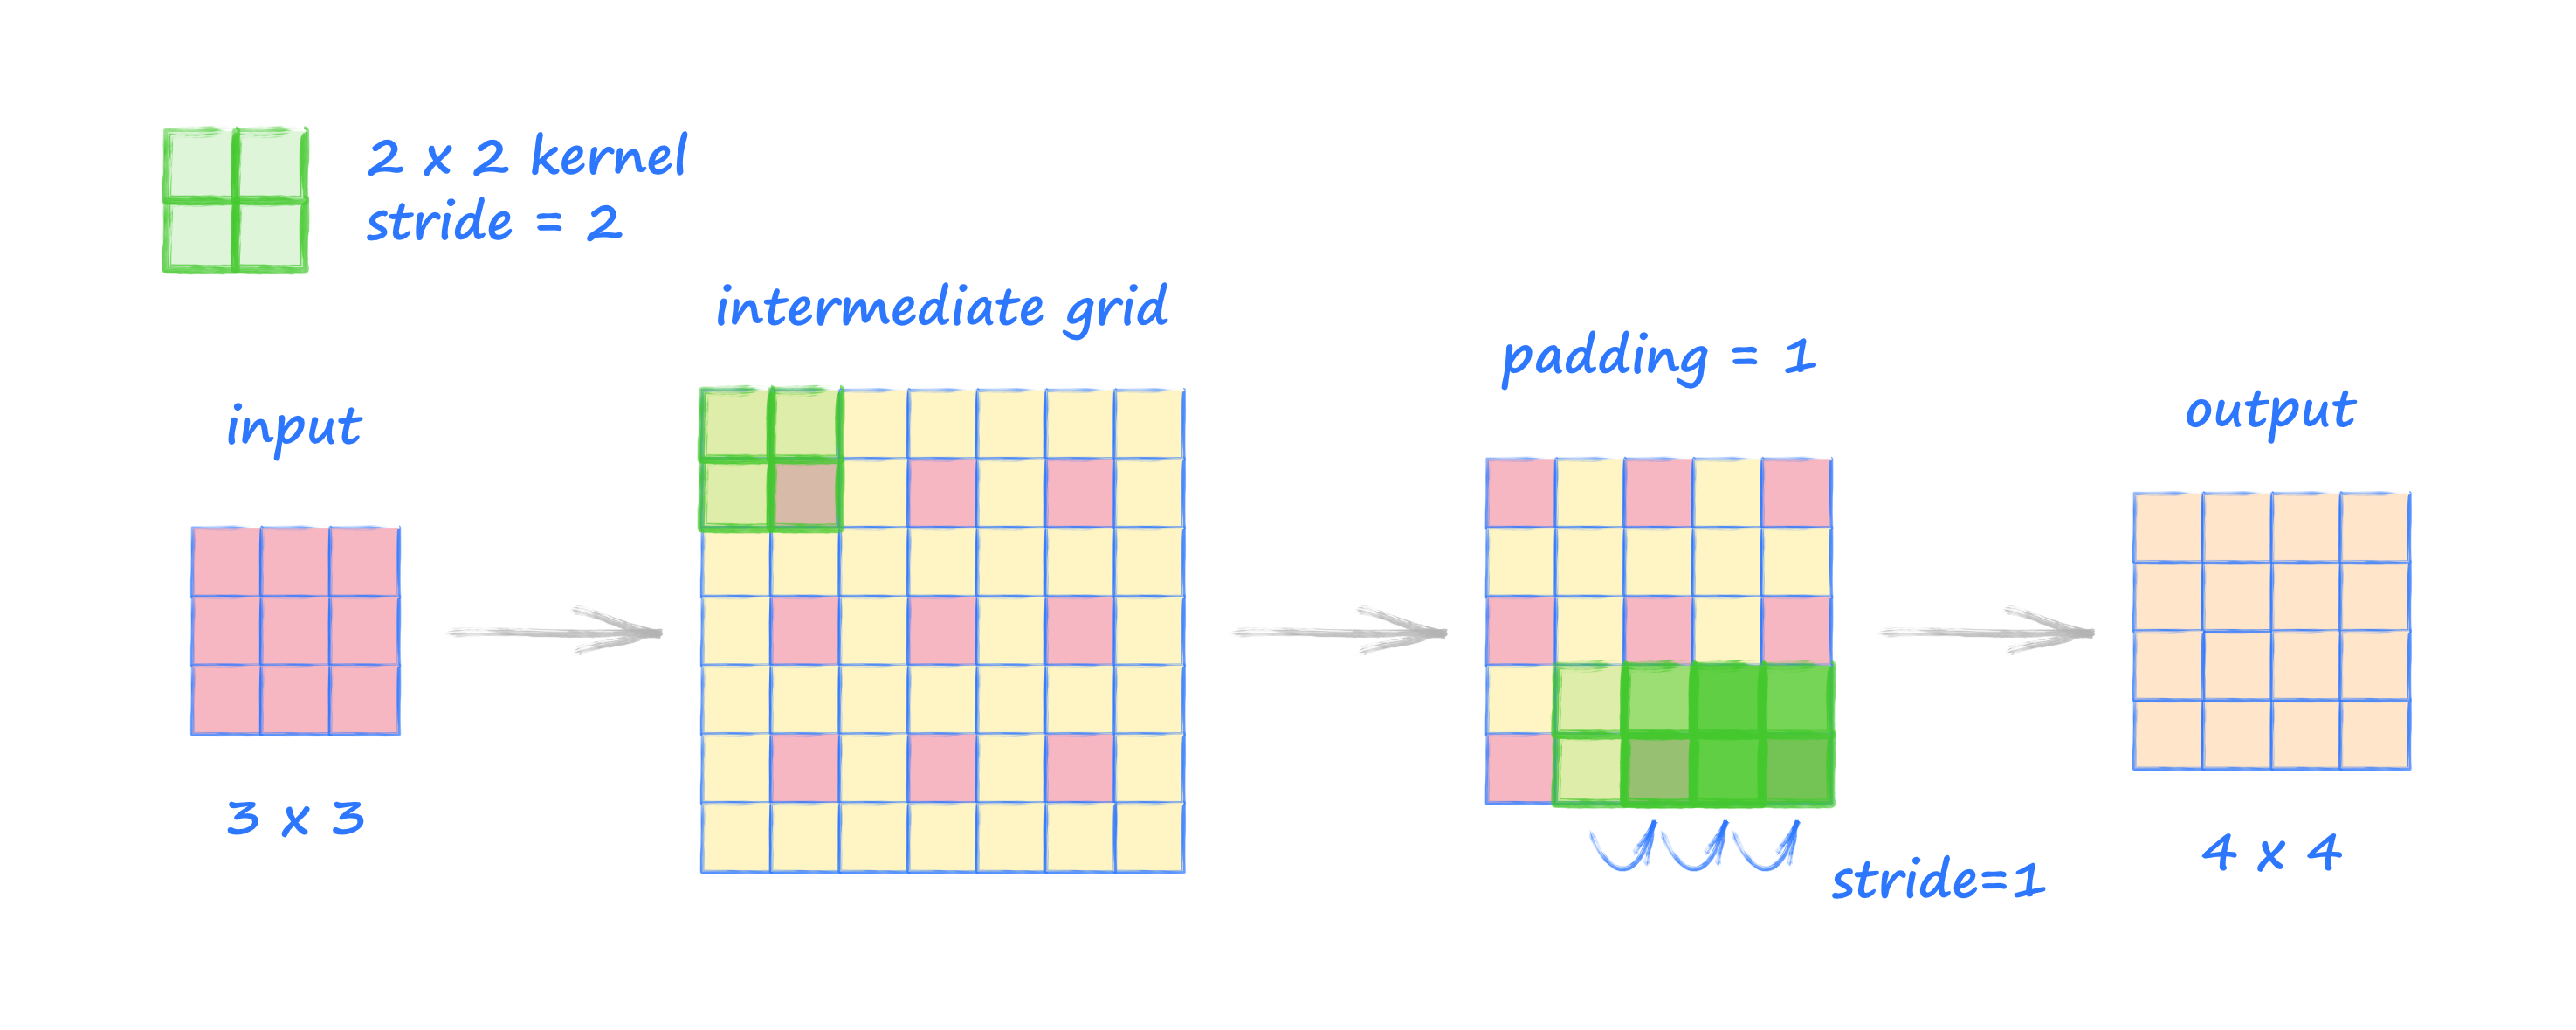

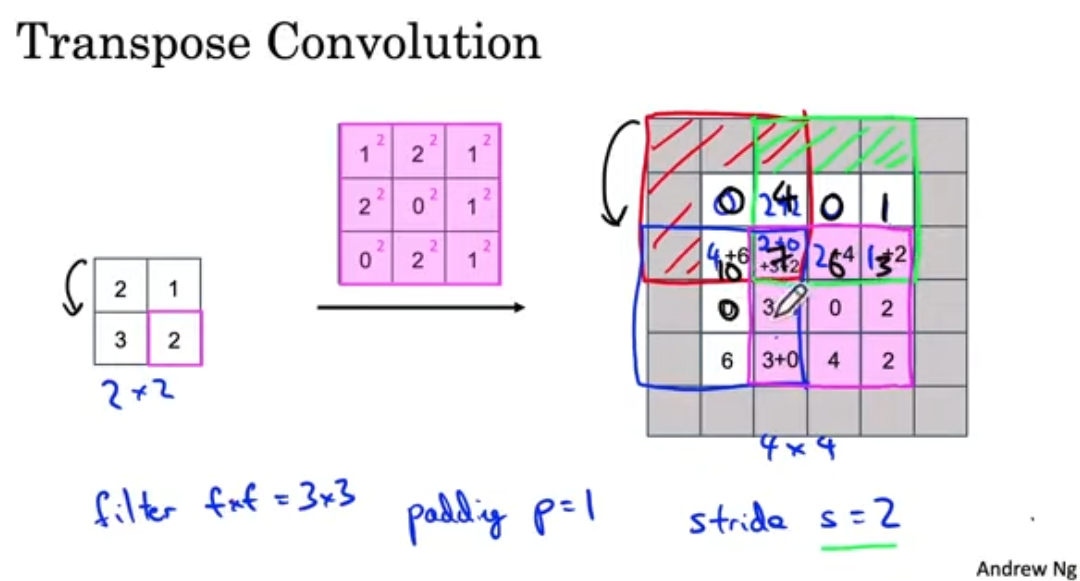

In [87]:
# Decoder get input vector from the encoder output
# The vector shape is (2,)
decoder_input = layers.Input(
    shape=(2,),
    name='decoder_input'
)

#  Turn vector of 2 elemnts into a flat vector of 2048 elements
x= layers.Dense(
    np.prod(shape_befoure_flattening)
)(decoder_input)

# Reshape vector into a Tensor
# # Restore Vector from the latent space into the 3d Tensor shape of 4x4x128
x = layers.Reshape(
    shape_befoure_flattening
)(x)

# Output Tenzor shape 8x8x128
x = layers.Conv2DTranspose(
    128,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(x)

# Output Tensor 16x16x64
x = layers.Conv2DTranspose(
    64,
    (3,3),
    strides=2,
    padding='same'
)(x)

# Output Tensor 32z32x32
x = layers.Conv2DTranspose(
    32,
    (3,3),
    strides=2,
    activation='relu',
    padding='same'
)(x)

# Output Tensor shape of 32x32x1(Generating b&w imgae shape 32x32) with sigmoid normalization
decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output'
)(x)

In [88]:
decoder = models.Model(decoder_input,decoder_output)

## FULL AUTOENCODER

Joining encoder to the decoder

In [89]:
# The Keras Model defines the full autoencoder— a model that takes an image and passes it through the encoder and back out through the decoder 
# to generate a reconstruction of the original image.
autoencoder = models.Model(encoder_input, decoder(encoder_output))

In [90]:
autoencoder.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

# COMPILE MODEL

**CHOOSING THE LOSS FUNCTION**

Optimizing for RMSE means that your generated output will be symmetrically distributed around the average pixel values (because an overestimation is penalized equivalently to an underestimation). On the other hand, binary cross-entropy loss is asymmetrical—it penalizes errors toward the extremes more heavily than errors toward the center. For example, if the true pixel value is high (say 0.7), then generating a pixel with value 0.8 is penalized more heavily than generating a pixel with value 0.6. If the true pixel value is low (say 0.3), then generating a pixel with value 0.2 is penalized more heavily than generating a pixel with value 0.4. This has the effect of binary cross-entropy loss producing slightly blurrier images than RMSE loss (as it tends to push predictions toward 0.5), but sometimes this is desirable as RMSE can lead to obviously pixelized edges.

In [91]:
autoencoder.compile(
    optimizer='adam',
    loss='binary_crossentropy' #  binary crossentropy between the individual pixels of the original image and the reconstruction.
)

# TRAIN MODEL

In [92]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    shuffle=True
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2992
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2551
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2520
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.2504
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.2487


# RECONSTRUCT IMAGES

In [93]:
n_to_predict = 5000

example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions = autoencoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


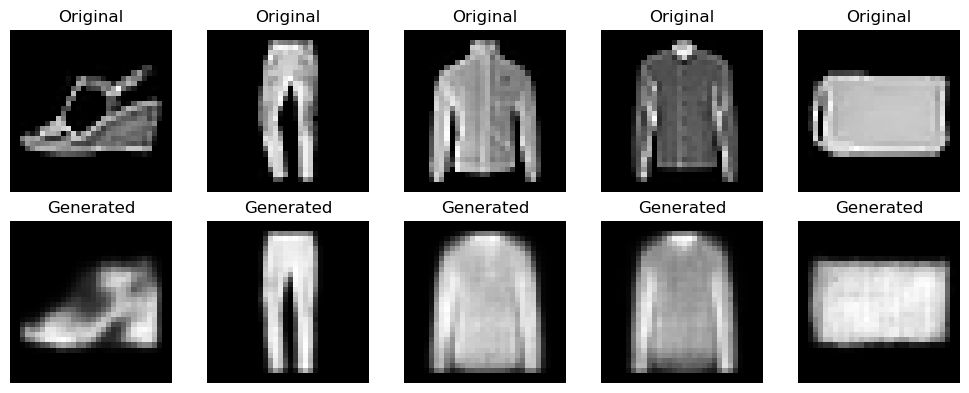

In [94]:
show_random_predictions(example_images, predictions, n=5)

**SUMMARY**

Notice how the reconstruction isn’t perfect—there are still some details of the original images that aren’t captured by the decoding process, such as logos. This is because by reducing each image to just two numbers, we naturally lose some information.

# LATENT SPACE

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


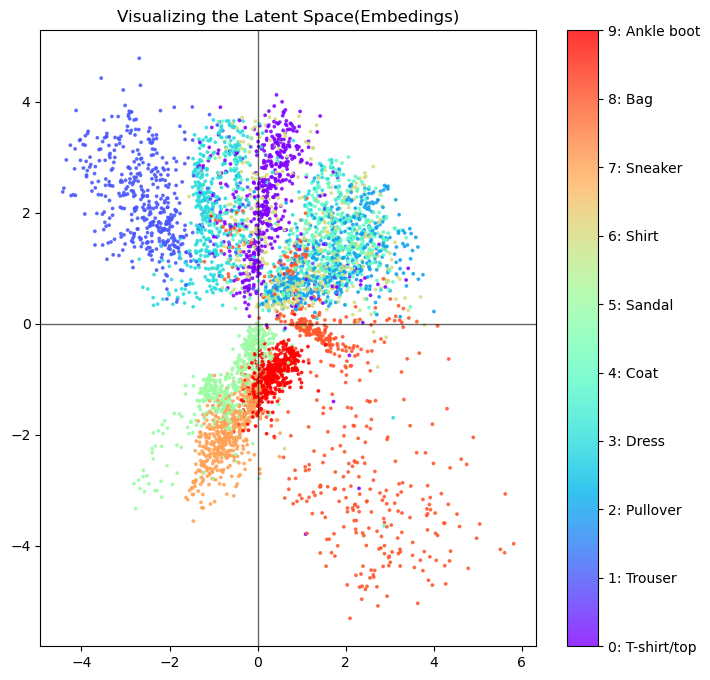

In [95]:
embedings = encoder.predict(example_images)

class_labels = {
    0: "0: T-shirt/top",
    1: "1: Trouser",
    2: "2: Pullover",
    3: "3: Dress",
    4: "4: Coat",
    5: "5: Sandal",
    6: "6: Shirt",
    7: "7: Sneaker",
    8: "8: Bag",
    9: "9: Ankle boot",
}

# Convert label ID's into a text
text_labels = [class_labels[label] for label in example_labels]

figsize = 8
plt.figure(figsize=(figsize, figsize))
sc = plt.scatter(
    embedings[:, 0],
    embedings[:, 1], 
    c=example_labels,
    cmap="rainbow",
    alpha=0.8,
    s=3
)

plt.axhline(0, color='black', linewidth=1, alpha=0.6)  
plt.axvline(0, color='black', linewidth=1, alpha=0.6) 

cbar = plt.colorbar(sc, ticks=np.arange(10))

# Add text labels
cbar.set_ticklabels([class_labels[i] for i in range(10)]) 

plt.title("Visualizing the Latent Space(Embedings)")
plt.show()

**Summary**

The each point on a resulting scatter plot shown above represents an image that has been embedded into the latent space, and each color represents cloth category.

Note: That our encoder's work finishes calculation with a flat vector of 2 elements, and exactly these elements are represented on this scater plot, where each element are interreted as a x,y cpprdinates of a dot

# GENERATE NEW IMAGES

In [96]:
# Get the range of the exinsting embedings
mins, maxs = np.min(embedings, axis=0), np.max(embedings,axis=0)

# Generate coordinates for 18 dots
sample = np.random.uniform(mins,maxs,size=(18,2))
reconstruction = decoder.predict(sample)

# Generate images for 18 dots
generated_images = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


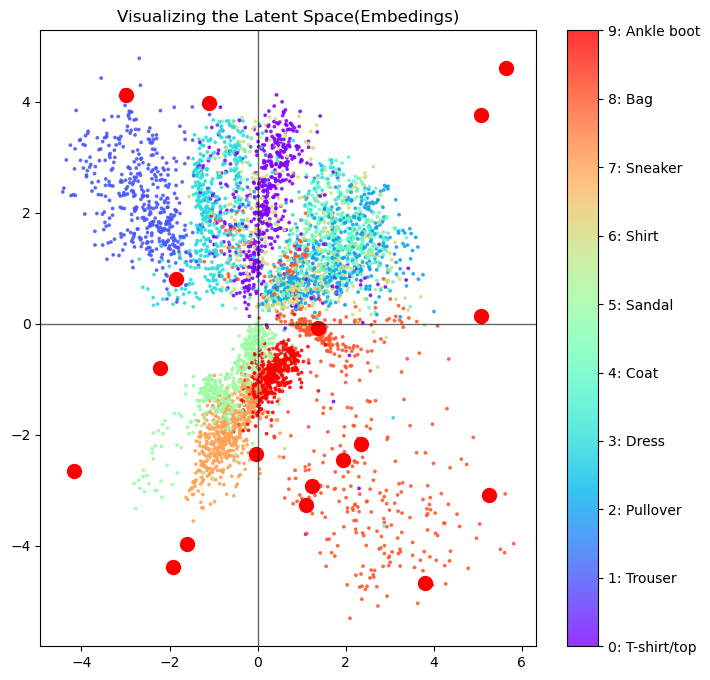

In [97]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
sc = plt.scatter(
    embedings[:, 0],
    embedings[:, 1], 
    c=example_labels,
    cmap="rainbow",
    alpha=0.8,
    s=3
)

plt.axhline(0, color='black', linewidth=1, alpha=0.6)  
plt.axvline(0, color='black', linewidth=1, alpha=0.6) 

cbar = plt.colorbar(sc, ticks=np.arange(10))

# Add text labels
cbar.set_ticklabels([class_labels[i] for i in range(10)]) 

plt.scatter(
    sample[:, 0],
    sample[:, 1],
    color='red',
    s=100,
    label='Generated Points'
)


plt.title("Visualizing the Latent Space(Embedings)")
plt.show()

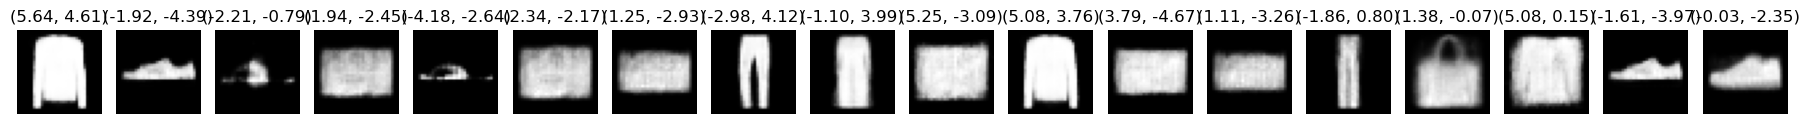

In [98]:
show_random_predictions2(sample, generated_images, reconstructed_classes=0, n=18)


**Summary**

Notice that some of the generated items are more realistic than others. This is because of the overall distribution of points in the latent space:

This problem is futher very well explained by David in his book. I do highly recomend you to open it on p.155 and read the reasons that are leading to this problem.

**References**

1. [Generative Deep Learning, 2nd Edition](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/): David Foster's book from which has become an inspiration of this notebook.
2. [David Foster](https://github.com/davidADSP): GitHub page
3. [David Foster (Keynote) - Generative Deep Learning -Key To Unlocking Artificial General Intelligence?](https://www.youtube.com/watch?v=rHLf78CmNmQ): David's video session at Youtube regarding some key concepts has written in his book
4. [Animated AI](https://www.youtube.com/@animatedai): Youtube channel with amazing visualizations of how exactly convolution is work.
5. [Make Your Own Neural Network](https://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html): Article explains convolution and T-convolution